In [4]:
import pandas as pd
import pyvista as pv
from glob import glob
import json
import os
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as vision_models
pv.start_xvfb()

In [5]:
tex_info = pd.read_json("/home/aleksandr/mount-folder/3D-FRONT-texture/texture_info.json")

In [12]:
tex_room = pv.read_texture("/home/aleksandr/mount-folder/3D-FRONT-texture/273a7787-72f5-4642-b333-03d06526035b/texture.png")

In [43]:
! ls /home/aleksandr/mount-folder/3D-FUTURE-model-part1 

In [5]:
f = open("existing_models.txt")
existing_model_ids = set(f.read().split("\n"))

In [6]:
model_info = pd.read_json("/home/aleksandr/mount-folder/3D-FUTURE-model-part1/model_info.json")
model_info

,model_id,super-category,category,style,theme,material
0,f89da2db-ad8c-4582-b186-ed2a46f3cb15,Sofa,armchair,Minimalist,Gold Foil,Rough Cloth
1,5de45849-7d1b-4378-82da-ed183b7ecc37,Chair,Lounge Chair / Cafe Chair / Office Chair,Ming Qing,Floral,Rough Cloth
2,1ef668a9-12e0-447b-9bbc-8ae484ba8c58,Lighting,Pendant Lamp,Modern,None,None
3,0d3e3b3c-3f1a-47ee-8566-1052cb8635b6,Cabinet/Shelf/Desk,Coffee Table,Modern,Texture Mark,Wood
4,16febe29-52d9-4833-a695-b09446e65512,Cabinet/Shelf/Desk,Corner/Side Table,Modern,Cartoon,Composite Board
...,...,...,...,...,...,...
16558,328918d2-1121-4f2e-bb63-fb1ecadc687a,Others,None,Modern,None,None
16559,5e5c01c1-e9a0-4eff-a059-0c9ea5afae9c,Lighting,Ceiling Lamp,Modern,None,None
16560,908e38ac-35ca-4aa2-ad9f-8402fc7ae8ed,Others,None,Modern,None,None
16561,966e026d-c284-438e-99a1-2baba6379d3f,Others,None,Modern,None,None


In [11]:
model_info[model_info["model_id"].isin(model_ids[:n])]

,model_id,super-category,category,style,theme,material
870,0033e020-460c-4990-a2d2-cfe223a2f5a0,Cabinet/Shelf/Desk,Children Cabinet,Korean,Cartoon,Others
1066,0050f47f-0d3e-46c7-8a0d-47a16b524e96,Table,Dining Table,Modern,Smooth Net,Composite Board
2512,006cb2b3-e9e3-34e3-9a0e-f93fa04f344b,Table,Dining Table,Japanese,Texture Mark,Solid Wood
4719,007a52b4-27db-4430-b754-4fc5f254e917,Table,Dressing Table,Modern,Smooth Net,Composite Board
4720,00859a4c-8945-4665-92e5-69ab8fba6593,Sofa,Three-Seat / Multi-seat Sofa,Minimalist,Smooth Net,Smooth Leather
5449,006a08bb-914c-49b9-93ed-4de256ae74c2,Cabinet/Shelf/Desk,TV Stand,American Country,Chinese Pattern,Wood
5482,003a85cc-1a58-4b93-8b5c-11ad960aded5,Sofa,armchair,Southeast Asia,Smooth Net,Others
5687,007498dc-954a-4ddc-b318-164b7e4dfefc,Bed,King-size Bed,Modern,Smooth Net,Rough Cloth
6055,009ac457-0558-494c-bffa-72c4c0960649,Cabinet/Shelf/Desk,Coffee Table,Modern,Gold Foil,Marble
6499,005bafee-92c1-41db-ac9b-dab97ef3756f,Sofa,Three-Seat / Multi-seat Sofa,Modern,Smooth Net,Rough Cloth


9


/home/aleksandr/anaconda3/envs/space_match/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


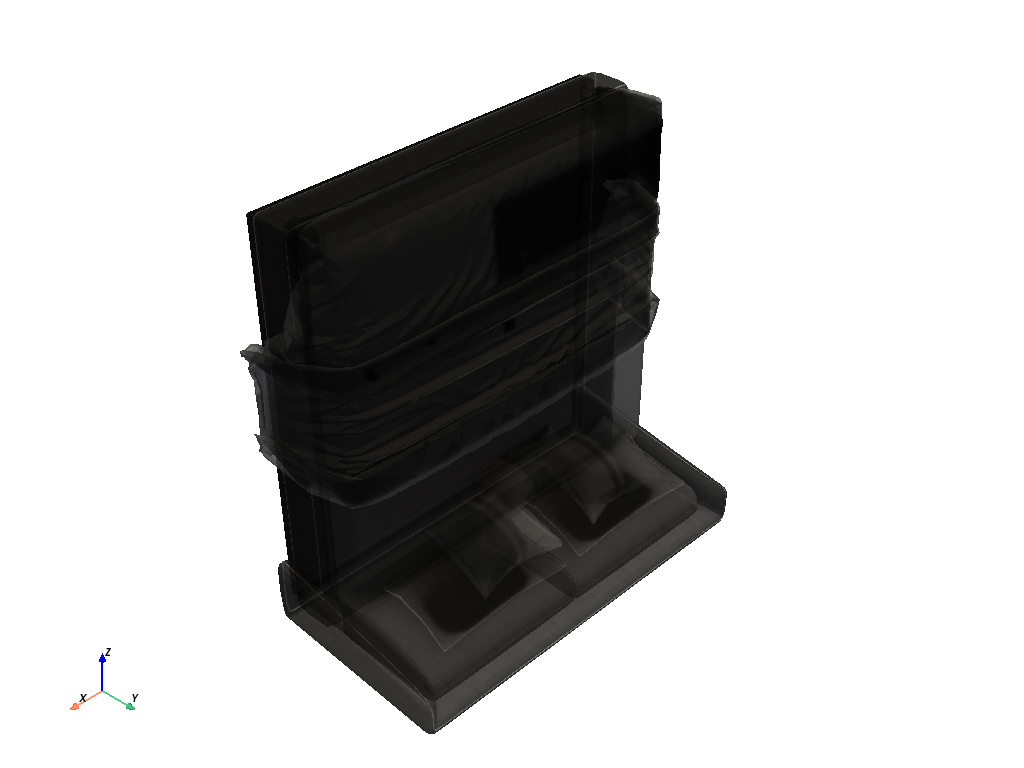

6


/home/aleksandr/anaconda3/envs/space_match/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


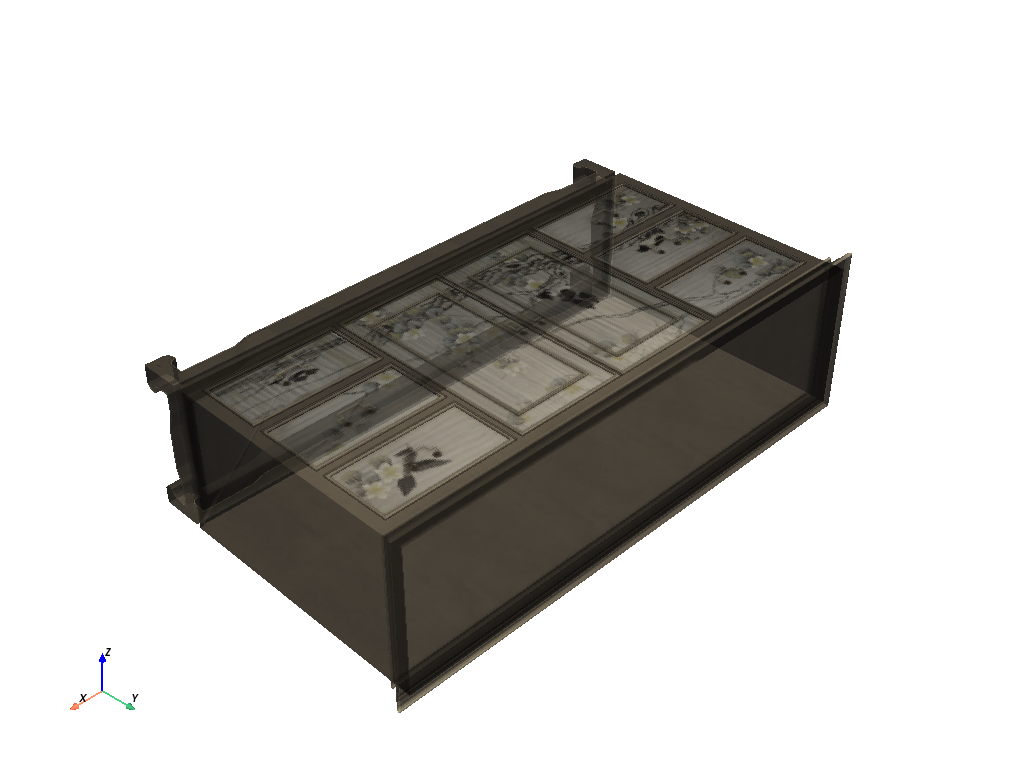

13


/home/aleksandr/anaconda3/envs/space_match/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


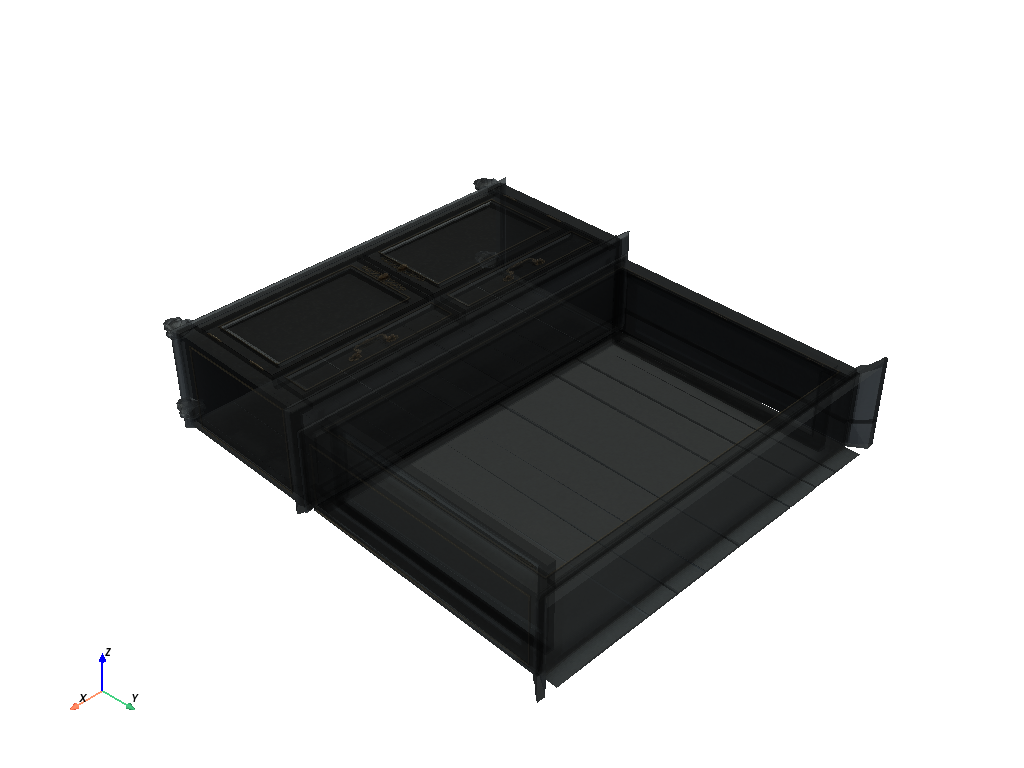

In [13]:
for i in [9, 6, 13]:
    print(i)
    models[i]["model"].plot(texture=models[i]["texture"])

In [6]:
# model_info.groupby("super-category")["category"].unique().explode()

In [10]:
n = 20
dir = "/home/aleksandr/mount-folder/3D-FUTURE-model-part1"
# model_ids = existing_model_ids & set(model_info["model_id"])
model_ids = sorted(existing_model_ids & set(model_info["model_id"])) #[model_info["category"] == "King-size Bed"]
model_ids = list(model_ids)
models = []
for name in model_ids[:n]:
    f = os.path.join(dir, name)
    models.append({
        "model": pv.read(os.path.join(f, "normalized_model.obj")),
        "texture": pv.read_texture(os.path.join(f, "texture.png"))
    })
# m = pv.read("/home/aleksandr/mount-folder/3D-FUTURE-model-part1/ffde330f-dce0-4215-bfe6-203fe615b609/raw_model.obj")
# norm_m = pv.read("/home/aleksandr/mount-folder/3D-FUTURE-model-part1/ffde330f-dce0-4215-bfe6-203fe615b609/normalized_model.obj")
# tex = pv.read_texture("/home/aleksandr/mount-folder/3D-FUTURE-model-part1/ffde330f-dce0-4215-bfe6-203fe615b609/texture.png")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: Interlace handling should be turned on when using png_read_image


In [14]:
def crop_object(image_array):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

    gray = np.where(gray==255, 0, gray)

    # # Find contours in the binary mask
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # # Find the largest contour (assumed to be the object)
    largest_contour = max(contours, key=cv2.contourArea).squeeze()

    bottom_right = largest_contour.max(0)
    top_left = largest_contour.min(0)

    # TODO: add boundaries checker
    cropped_image_array = image_array[top_left[1]: bottom_right[1] + 1,
                                      top_left[0]: bottom_right[0] + 1, :]
    return cropped_image_array

def create_views(mesh, texture, positions):
    model_views = []
    for position in positions:
        pl = pv.Plotter()
        pl.camera_position = position
        # Remove transparency, TODO: explore this choice
        no_transp_texture = pv.numpy_to_texture(texture.to_array()[..., :-1])
        pl.add_mesh(mesh, texture=no_transp_texture)
        model_views.append(crop_object(pl.screenshot(return_img=True)))
    return model_views

In [15]:
# # axes = pv.Axes(show_actor=True, actor_scale=1.0)
# camera_distance=5

# # front_view_camera_position = np.array([(0, -camera_distance, 0), (0, 0, 0), (0, 0, 1)])
# # rotated_camera_position = front_view_camera_position.dot(np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 1]]))
# # plotter.camera_position = rotated_camera_position
# positions = [
#     [(0, camera_distance, 0), (0, 0, 0), (0, 0, -1)],
#     [(0, -camera_distance, 0), (0, 0, 0), (0, 0, -1)],
#     [(0, 0, camera_distance), (0, 0, 0), (0, 1, 0)],
#     [(-camera_distance, 0, 0), (0, 0, 0), (0, 1, 0)],
#     [(camera_distance, 0, 0), (0, 0, 0), (0, 1, 0)],
#     [(0, 0, -camera_distance), (0, 0, 0), (0, 1, 0)],
# ]
# views = []
# for m in models:
# #     pl.camera_position = [(3.2257270137110754, 3.640847078923325, 3.2256104866305395),
# #  (0.0, 0.41512006521224976, -0.00011652708053588867),
# #  (0.0, 0.0, 1.0)]
#     # pl.camera.zoom(0.3)
#     # pl.add_actor(axes.actor)
#     one_model_views = []
#     for position in positions:
#         pl = pv.Plotter()
#         pl.camera_position = position
#         pl.add_mesh(m["model"], texture=m["texture"])
#         # pl.add_texture(texture=m["texture"])
#         one_model_views.append(crop_object(pl.screenshot(return_img=True)))
#     views.append(one_model_views)

In [16]:


class FeatureExtractor:
    def __init__(self, model_name='resnet50', feature_layer=None):
        self.model_name = model_name
        self.feature_layer = feature_layer
        
        # Load the pretrained model
        self.model = self._load_pretrained_model()
        self.model.eval()
        
        # Define the transformations
        self.transform = self._get_transform()
    
    def _load_pretrained_model(self):
        # Load the pretrained model from torchvision
        if self.model_name == 'resnet50':
            model = vision_models.resnet50(pretrained=True)
        elif self.model_name == 'vgg16':
            model = vision_models.vgg16(pretrained=True)
        else:
            raise ValueError('Invalid model_name. Supported models: resnet50, vgg16')
        
        # Replace the last fully connected layer with an identity layer
        if self.feature_layer is not None:
            model.fc = torch.nn.Identity()
        
        # Move the model to GPU if available
        if torch.cuda.is_available():
            model = model.cuda()
        
        return model
    
    def _get_transform(self):
        # Define the transformations based on the chosen model
        if self.model_name == 'resnet50':
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        elif self.model_name == 'vgg16':
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            raise ValueError('Invalid model_name. Supported models: resnet50, vgg16')
        
        return transform
    
    def extract_features(self, images):
        _images = images if isinstance(images, list) else [images]

        # Apply transformations to the image
        transformed_images = []
        for image in _images:
            transformed_images.append(self.transform(image))
        transformed_images = torch.stack(transformed_images)
        
        # Move the image to GPU if available
        if torch.cuda.is_available():
            transformed_images = transformed_images.cuda()
        
        # Forward pass through the model
        with torch.no_grad():
            features = self.model(transformed_images)
        
        # Return the concatenated features
        return features.cpu().squeeze().flatten()


In [17]:
class StyleRanker:
    def __init__(
        self, 
        model_name="resnet50",
        feature_layer=None, 
        positions=None, 
        camera_distance=5
    ):
        self.feature_extractor = FeatureExtractor(model_name=model_name, feature_layer=feature_layer)
        self.cossim = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
        self.camera_distance = camera_distance
        if not positions:
            self.positions = [
                [(0, camera_distance, 0), (0, 0, 0), (0, 0, -1)],
                [(0, -camera_distance, 0), (0, 0, 0), (0, 0, -1)],
                [(0, 0, camera_distance), (0, 0, 0), (0, 1, 0)],
                [(-camera_distance, 0, 0), (0, 0, 0), (0, 1, 0)],
                [(camera_distance, 0, 0), (0, 0, 0), (0, 1, 0)],
                [(0, 0, -camera_distance), (0, 0, 0), (0, 1, 0)],
            ]
    
    def _extract_features_from_object(self, object):
            object_views = create_views(
                object["model"], 
                object["texture"], 
                positions=self.positions)
            return self.feature_extractor.extract_features(object_views)

    def __call__(self, context, targets):
        _targets = targets if isinstance(targets, list) else [targets]
        _context = context if isinstance(context, list) else [context]

        aggregated_features = None
        for context_object in _context:
            features = self._extract_features_from_object(context_object)
            aggregated_features = (
                aggregated_features + features) if aggregated_features is not None else features

        scores = torch.zeros(len(_targets))
        for idx, target in enumerate(_targets):
            features = self._extract_features_from_object(target)
            scores[idx] = self.cossim(aggregated_features, features)
        return scores

In [18]:
ranker = StyleRanker()
context = [models[6], models[9], models[13]]
targets = [models[i] for i in range(len(models)) if i not in [6,9,13]]
del models

In [19]:
scores = ranker(context, targets)

In [22]:
best_idx = int(scores.argmax())

/home/aleksandr/anaconda3/envs/space_match/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


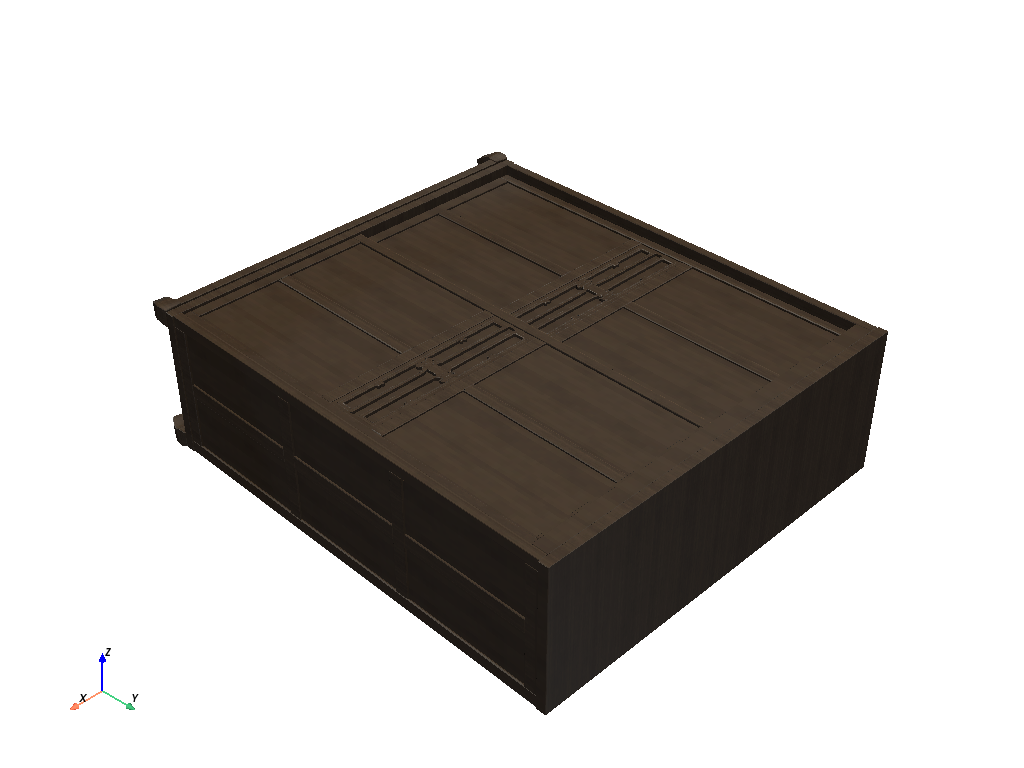

IndexError: list index out of range

In [24]:
targets[best_idx]['model'].plot(texture=pv.numpy_to_texture(targets[best_idx]['texture'].to_array()[..., :-1]))
context[0]['model'].plot(texture=pv.numpy_to_texture(context[0]['texture'].to_array()[..., :-1]))
context[1]['model'].plot(texture=pv.numpy_to_texture(context[1]['texture'].to_array()[..., :-1]))
context[2]['model'].plot(texture=pv.numpy_to_texture(context[2]['texture'].to_array()[..., :-1]))